# <center><font color='red'>The foodie app</font><center>
> <center><h3>What are we having for supper?</h3></center>

<center><img src=https://miro.medium.com/max/1400/1*9AXti3Lgxm7vi9BLIRDc1A.png><center>


**Team members:** Rhodasi, Dennies, Margaux

**Tutor:** Emmanuel

**This is the the 2nd part of our notebook**

NB: the notebook was too large to render in Github so we split



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spacy
!pip install spacy-langdetect
!python -m spacy download en
!python -m spacy download en_core_web_sm
!pip install en_core_web_sm
!pip install spacytextblob

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.2.0/en_core_web_sm-3.2.0-py3-none-any.whl (13.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 13.9 MB 1.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import json
import re

import pickle
import string
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap,MarkerCluster
import folium

#modules and libraries for training
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report, confusion_matrix


import spacy
from spacy_langdetect import LanguageDetector



## **Import the files needed** 

Needed here because we had to split the notebook 

## **1) Business File**

In [ ]:
#load dataset 
path_to_business = '/content/drive/MyDrive/DSI module3/Data/yelp_academic_dataset_business.json.zip'   # path to change if needed
business=pd.read_json(path_to_business, lines=True)

business.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None


In [ ]:
# Select only restaurants from all the businesses in the dataset and the once that are still open
business['restaurant']= business.categories.str.contains(pat='Restaurants|Restaurant|food',flags=re.IGNORECASE, regex=True)
print(business[business.restaurant == True].shape)
resto = business[(business.restaurant == True) & (business.is_open == 1)]
print(resto.shape)
resto.head()

(64629, 15)
(44594, 15)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,restaurant
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",True
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",True
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",True
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",True


## **2) The Reviews File**

In [ ]:
path_to_reviews = r'/content/drive/MyDrive/DSI module3/Data/yelp_academic_dataset_review.json'  # to change if needed

# loading in chunk because of its size
reviews = None
with pd.read_json(path_to_reviews, lines=True, chunksize=5000) as reader:
    reader
    for chunk in reader:
        if reviews is None:
            reviews = chunk
        else:
            reviews = reviews.append(chunk)


**Because we want a fast app and time constraints (longer time needed to train model), we have limited our dataset to the restaurants in one region: 
between -80 and -70 in longitude which correspond to 4 states in the USA: PA, NJ, DE, NV**

With more time and resources, we would have expand this to more restaurants in other regions and offer the user to choose a location (with a perimeter) on the app. 

In [ ]:
# we are here selecting based on the longitude
resto_NW = resto[(resto.longitude>-80) & (resto.longitude<-70)]
print(resto_NW.state.unique())
print(resto_NW.shape)
resto_NW.head()

['PA' 'NJ' 'DE' 'NV']
(14106, 15)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,restaurant
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",True
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",True
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",True
33,kV_Q1oqis8Qli8dUoGpTyQ,Ardmore Pizza,10 Rittenhouse Pl,Ardmore,PA,19003,40.006707,-75.289671,3.5,109,1,"{'RestaurantsGoodForGroups': 'True', 'WiFi': '...","Pizza, Restaurants","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",True


In [ ]:
# select a subset of the review dataset to use for the app
reviews_NW = reviews[(reviews['business_id'].isin(resto_NW.business_id))]
print(reviews_NW.shape)
reviews_NW.head()

(1102090, 9)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25
19,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5,0,0,0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27
26,G_5UczbCBJriUAbxz3J7Tw,clWLI5OZP2ad25ugMVI8gg,x4XdNhp0Xn8lOivzc77J-g,5,0,0,0,Best thai food in the area. Everything was au...,2013-08-15 15:27:51


In [ ]:
# to use in case of memory issues although it will be needed at the start of the sentiment analyses model
# import gc
# del reviews
# gc.collect()

### **Pre-processing Helper**
> This applies a simple natural language processing pipeline to our text.

In [ ]:
#Tokenization and pre-processing for nlp
punct = string.punctuation
from spacytextblob.spacytextblob import SpacyTextBlob
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("spacytextblob")
stopwords = list(STOP_WORDS)


def text_data_cleaning(sentence):
    '''
    
    Takes a text and pre-processes it for downstream nlp
    input: single document
    output: returns a tokenised document
    
    '''
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens



---



<center><img src="https://www.printweek.com/media/169013/customerfeedback-pic.jpg?anchor=center&mode=crop&width=960&height=640&rnd=132179756770000000" ></center>


# <font color='red'>**Sentiment Analyses model**</font>

This is the second "bloc" of our application. Here we trained a sentiment analyses model to asses each review. We could have just use the star rating, but we know that stars are not always true represention of the reviewer sentiment, as much as we know that the review on its own is not always enough to assess the quality of a restaurant.  

Most of the dataset available online only had 2 (or 5) sentiment such as positive/negative or like/dislike (or 5 stars) as the response variable. Hence we decided to create our own sentiment score based on 3 criteria:


*   Polarity of the review
*   Proportion of positive to negative words as a function of the total number of words
*   the star rating of that reviewer 

## **1) Create a training dataset and sentiment score**

**1.1. Extract a trained balanced subset**

Here we are creating the trained data and only selected the reviews that are in english.
We choose 5000 per star categories but with more time we could try with a larger dataset and see if it could improve the model accuracy



In [ ]:
# we decided here to take 5000 reviews in each star category to have a balance training set
train_df_all = reviews.groupby('stars').apply(lambda x: x.sample(5000))

In [ ]:
# Remove the reviews that aren't in english
nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

def detect_language(text):
  doc = nlp(text)
  lang = doc._.language
  return list(lang.values())[0]

rev_to_remove=[]
for i,text in enumerate(train_df_all['text']):
  lan = detect_language(text)
  if lan != 'en':
    #print(lan)
    rev_to_remove.append(train_df_all.review_id.iloc[i])


train_df = train_df_all[~train_df_all['review_id'].isin(rev_to_remove)]
train_df.shape

(24746, 9)

In [ ]:
train_df.head()

,business_id,review_id,user_id,stars,date,text,useful,funny,cool
0,--9e1ONYQuAa-CB_Rrw7Tw,HzB-6zA84zFePbzif_5D3g,uqPNpQ6LdHTtG_TnB7x4qA,2,2011-11-07,Over-rated!!!!!!!!! My steak was overly season...,0,0,0
1,--9e1ONYQuAa-CB_Rrw7Tw,c9lAv_pZYK6r1umrzAhnVA,3RGKgFproU4CflJVkAZw4w,2,2017-03-27,Rib eye steak for $51 should be pretty darn go...,1,0,1
2,--9e1ONYQuAa-CB_Rrw7Tw,A_erX_KsIdXA7P9upGlnFg,bWJWcQyDKtFSvsTW2tR3hw,3,2016-06-02,Good but not great for a high end steakhouse.\...,2,1,1
3,--9e1ONYQuAa-CB_Rrw7Tw,tsxxhdbtjme27b5zmdnmGQ,55fW1D1K79xLH2AKPWVVWw,3,2011-07-06,Of the half dozen or so high-end steakhouses I...,0,0,1
4,--9e1ONYQuAa-CB_Rrw7Tw,7fYoPiMa20VwN3mNAa_KMw,VqnKOb7vZU11BBmx7mUltQ,3,2017-02-25,"Steak was very tough. Surprising for $55.00, I...",0,0,0


**1.2. Stemming and Lemmatization of the reviews**

NLP and ML in general require some pre-processing steps of text to improve performances. Here we first clean the reviews by removing capital letters, stop words, and then we used 2 technics that are **stemming** and **lemmatization**. They both reduce the words to their root forms, however as described in the example below lemmatization always return a meaningfull words while steming does not.

<img src=https://miro.medium.com/max/1400/1*ES5bt7IoInIq2YioQp2zcQ.png width="500"/>

In [ ]:
import textblob
from textblob import Word
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# create "cleaned" reviews with only lowercase and without punctuations
lowercase = train_df['text'].apply(lambda x: ' '.join(word.lower() for word in str(x).split()))
train_df['cleaned'] = lowercase.str.replace('[^\w\s]', '') # new col

Reviews_noStopWords = []

for i in range(len(train_df)):
    review = str(train_df['cleaned'][i])
    review = review
    review = review.lower()
    
    stop_words = set(stopwords.words('english'))  # remove stop words
    word_tokens = word_tokenize(review)           # tokenised
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
 
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    
    Reviews_noStopWords.append(filtered_sentence)

train_df['No_Stop_Words:Tokens'] = Reviews_noStopWords
print(train_df['No_Stop_Words:Tokens'][0:3])


# make "sentences" using the tokens from above (no stop words, etc)
train_df['No_Stop_Words:Sentence'] = Reviews_noStopWords
for i in range(len(train_df)): 
    text_list = train_df['No_Stop_Words:Tokens'][i]
    blank = ''
    for word in text_list:
        blank = blank +' '+ word
    train_df['No_Stop_Words:Sentence'][i] = blank
print(train_df['No_Stop_Words:Sentence'][0:3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


0    [overrated, steak, overly, seasoned, way, salt...
1    [rib, eye, steak, 51, pretty, darn, good, got,...
2    [good, great, high, end, steakhouse, atmospher...
Name: No_Stop_Words:Tokens, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0     overrated steak overly seasoned way salty lik...
1     rib eye steak 51 pretty darn good got tender ...
2     good great high end steakhouse atmosphere b n...
Name: No_Stop_Words:Sentence, dtype: object


In [ ]:
# Lemmatization
train_df['lemmatized'] = train_df['No_Stop_Words:Sentence'].apply(lambda x: ' '.join(Word(word).lemmatize() for word in x.split()))
print(train_df['lemmatized'][0:3])

0    overrated steak overly seasoned way salty liki...
1    rib eye steak 51 pretty darn good got tender f...
2    good great high end steakhouse atmosphere b ni...
Name: lemmatized, dtype: object


In [ ]:
# Stemming the reviews (on the lemmatised col)
stemmed_list = []
snowBallStemmer = SnowballStemmer("english")

for i in range(len(train_df)):
    sentence = train_df['lemmatized'][i]
    wordList = nltk.word_tokenize(sentence)
    stemWords = [snowBallStemmer.stem(word) for word in wordList]
    
    stemmed = ' '.join(stemWords)
    stemmed_list.append(stemmed)

train_df['Stemmed'] = stemmed_list

In [ ]:
# Create token of for the stemmed sentence

def word_extraction(sentence):   
    words = re.sub("[^\w]", " ",  sentence).split()    
    cleaned_text = [w.lower() for w in words]    
    return cleaned_text

stemmed_tokens_list = []
for i in range(len(train_df)):
    stemmed = train_df['Stemmed'][i]
    tokens = word_extraction(stemmed)
    stemmed_tokens_list.append(tokens)

train_df['Stemmed_tokens'] = stemmed_tokens_list
print(train_df['Stemmed_tokens'][0:3])

0    [overr, steak, over, season, way, salti, like,...
1    [rib, eye, steak, 51, pretti, darn, good, got,...
2    [good, great, high, end, steakhous, atmospher,...
Name: Stemmed_tokens, dtype: object


**1.3. Calculate polarity and subjectivity**

We used the sentiment function of textblob which returns two properties: polarity and subjectivity, although here we will only use the polarity. 

Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. 

In [ ]:
##Using TextBlob create columns for the polarity and subjectivity of the review_text
from textblob import TextBlob
train_df['polarity'] = train_df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[0])
train_df['subjectivity'] = train_df['lemmatized'].apply(lambda x: TextBlob(x).sentiment[1])

**1.4. Calculate an index based on the proportion of positive and negative words**

This technique is another way of looking at the quality of a sentiment. It is the numner of positive words - number of negative words, the whole thing divided bu


In [ ]:
#Load positive and negative lexicons
file1 = open(r"/content/drive/MyDrive/DSI module3/Data/Positve_lexicon.txt", "r") #change directory
content1 = file1.read()
pos_lex = content1.splitlines()
pos_lex_stem = [snowBallStemmer.stem(word) for word in pos_lex] # to check when/if we need stemmed

file2 = open(r"/content/drive/MyDrive/DSI module3/Data/Negative_lexicon.txt", "r") #change directory
content2 = file2.read()
neg_lex = content2.splitlines()
neg_lex_stem = [snowBallStemmer.stem(word) for word in neg_lex] # to check when/if we need stemmed

In [ ]:
#Create positive and negative words count
pos_count = []
neg_count = []
prop_pos_neg = []

for i in range(len(train_df)):
    count_pos = 0
    count_neg = 0
    tokens = train_df['Stemmed_tokens'][i]
    for word in tokens:
      if word in pos_lex:  #if stemmed word - should use pos_lex_stem
          count_pos += 1
      elif word in neg_lex:   #if stemmed word - should use neg_lex_stem
          count_neg += 1
    pos_neg = (count_pos - count_neg)/len(tokens)  

    pos_count.append(count_pos)
    neg_count.append(count_neg)
    prop_pos_neg.append(pos_neg)
    
train_df['Pos_Word_Count'] = pos_count
train_df['Neg_Word_Count'] = neg_count
train_df['Prop_pos_neg_words'] = prop_pos_neg

**1.5. Combine the 3 criteria Polarity, star rating and proportion of positive/negative words**

In [ ]:
# we are first scaling the 3 indices
min_max_scaler = preprocessing.MinMaxScaler()
pol_scaled = min_max_scaler.fit_transform(np.array(train_df['polarity']).reshape(-1,1))
star_scaled = min_max_scaler.fit_transform(np.array(train_df['stars']).reshape(-1,1))
prop_pos_neg_scaled = min_max_scaler.fit_transform(np.array(train_df['Prop_pos_neg_words']).reshape(-1,1))

pol_scaled = [float(i) for i in pol_scaled]
star_scaled = [float(i) for i in star_scaled]
prop_pos_neg_scaled = [float(i) for i in prop_pos_neg_scaled]

# we have decided to average the 3 indeces here with same weight
train_df['sentiment_score'] = np.mean([pol_scaled,star_scaled,prop_pos_neg_scaled], axis=0)
 

**1.6. Classify into 20 categories from 1 (worst) to 20 (best)**

Because all the sentiment analyses models we found are classifiers, we transformed our sentiment score into 20 classes 

In [ ]:
# Classify the score into 20 catgories
sentiment_label = np.array(range(20))
levels = np.linspace(0,1,20)
  
sentiment = []
for i in range(len(train_df)):
    sentiment.append(np.where(train_df['sentiment_score'][i]>levels)[0][-1])  

train_df['sentiment'] = sentiment

In [ ]:
train_df.head(2)

,business_id,review_id,user_id,stars,date,text,useful,funny,cool,cleaned,...,lemmatized,Stemmed,Stemmed_tokens,polarity,subjectivity,Pos_Word_Count,Neg_Word_Count,Prop_pos_neg_words,sentiment_score,sentiment
0,--9e1ONYQuAa-CB_Rrw7Tw,HzB-6zA84zFePbzif_5D3g,uqPNpQ6LdHTtG_TnB7x4qA,2,2011-11-07,Over-rated!!!!!!!!! My steak was overly season...,0,0,0,overrated my steak was overly seasoned it was ...,...,overrated steak overly seasoned way salty liki...,overr steak over season way salti like everyon...,"[overr, steak, over, season, way, salti, like,...",-0.066667,0.366667,3,1,0.117647,0.421895,8
1,--9e1ONYQuAa-CB_Rrw7Tw,c9lAv_pZYK6r1umrzAhnVA,3RGKgFproU4CflJVkAZw4w,2,2017-03-27,Rib eye steak for $51 should be pretty darn go...,1,0,1,rib eye steak for 51 should be pretty darn goo...,...,rib eye steak 51 pretty darn good got tender f...,rib eye steak 51 pretti darn good got tender f...,"[rib, eye, steak, 51, pretti, darn, good, got,...",0.076983,0.605409,12,9,0.018072,0.416333,7


**1.7. Few EDA checks on the training dataset and the sentiment score we have created**

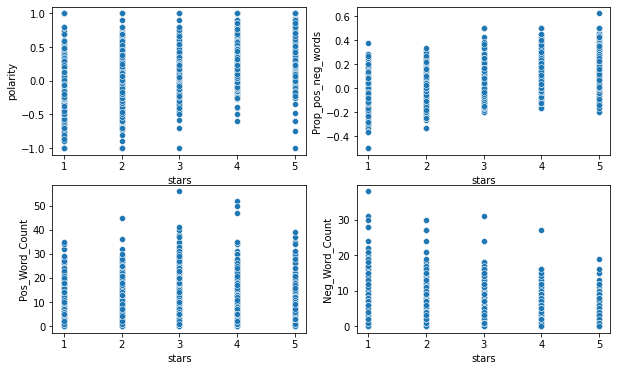

In [ ]:
# Description of the polarity and proportion of positive/negative words
# as a function to the star rating

fig, ax = plt.subplots(2,2, figsize=(10, 6))
sns.scatterplot(x='stars', y = 'polarity', data = train_df, ax=ax[0,0])
sns.scatterplot(x='stars', y = 'Prop_pos_neg_words', data = train_df, ax=ax[0,1])
sns.scatterplot(x='stars', y = 'Pos_Word_Count', data = train_df, ax=ax[1,0])
sns.scatterplot(x='stars', y = 'Neg_Word_Count', data = train_df, ax=ax[1,1])
plt.show()

We can see here that the polarity on its own seems to not vary that much between star rating while the proportion of positive to negative words seems to link slightly bettwe the star rating.
Although some of these aspects could be improved, we have decided to try with these indeces. We know that reviews and star rating are not always showing the same thing.

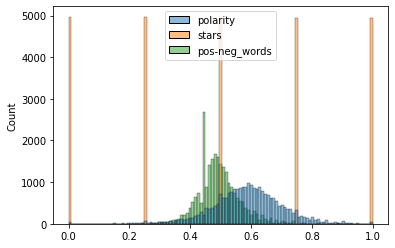

In [ ]:
# distribution of the 3 criteria we are using in the train_df after scaling
Scaled_scores = pd.DataFrame({'polarity':list(pol_scaled),
                              'stars': list(star_scaled),
                              'pos-neg_words':list(prop_pos_neg_scaled)})

sns.histplot(Scaled_scores)

plt.show()

We can see here that the dataset is not very well balanced with not many values at each extremes for the polarity and the proportion of positive/negative words. This potentially is a problem for the performance of our model. It is important to note however that this is a "natural" ocurrence in this type of dataset

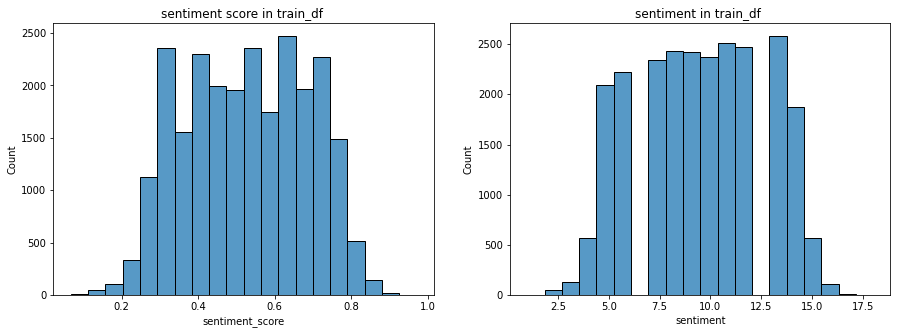

In [ ]:
# distribution of the sentiment score we calculated
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.histplot(x='sentiment_score',
              data=train_df,
              palette="RdYlBu",
              bins = 20, ax=ax[0]).set(title= 'sentiment score in train_df ')

sns.histplot(x='sentiment',
              data=train_df,
              palette="RdYlBu",
              bins = 20, ax=ax[1]).set(title= 'sentiment in train_df ')
plt.show()

Pooling the 3 indeces together and averaging them seems to somehow help a bit with the distribution of the sentiment score. We can see that the very "bad" and very "good" reviews are still not well represented.

We can also noticed that we could make some progress with the sentiment (values from 1 to 20) as we have some empty classes which aren't represented at all. We have tried less classes but we also had some classes with zero occurences.

Plost using the sentiment score


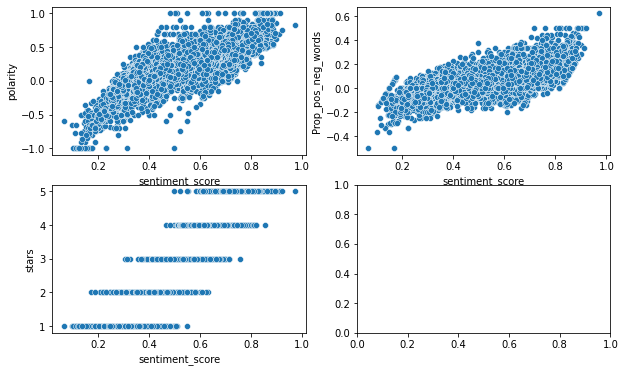

Plost using the sentiment values from 1 to 20


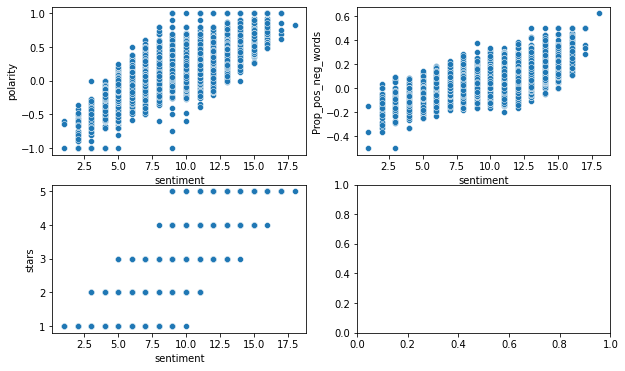

In [ ]:
print('Plost using the sentiment score')
fig, ax = plt.subplots(2,2, figsize=(10, 6))
sns.scatterplot(x='sentiment_score', y = 'polarity', data = train_df, ax=ax[0,0])
sns.scatterplot(x='sentiment_score', y = 'Prop_pos_neg_words', data = train_df, ax=ax[0,1])
sns.scatterplot(x='sentiment_score', y = 'stars', data = train_df, ax=ax[1,0])
plt.show()

print('Plost using the sentiment values from 1 to 20')
fig, ax = plt.subplots(2,2, figsize=(10, 6))
sns.scatterplot(x='sentiment', y = 'polarity', data = train_df, ax=ax[0,0])
sns.scatterplot(x='sentiment', y = 'Prop_pos_neg_words', data = train_df, ax=ax[0,1])
sns.scatterplot(x='sentiment', y = 'stars', data = train_df, ax=ax[1,0])
plt.show()

## **2) Training the sentiment model**

In [ ]:
# training target from unique label of the the sentiment column we created
y = train_df['sentiment']

# Logistic regression classifier

tfidf = TfidfVectorizer(tokenizer = text_data_cleaning)

clf = LogisticRegression(solver='saga')
X = train_df['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

clf = Pipeline([('tfidf', tfidf), ('clf', clf)])
clf.fit(X_train, y_train)

#filename = 'sentiment_model_20Classes.sav'
#pickle.dump(clf, open(filename, 'wb'))

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x7eff298bcd40>)),
                ('clf', LogisticRegression(solver='saga'))])

In [ ]:
# Prediction of the X_test
results = clf.predict(X_test)

In [ ]:
# Check accuracy of the model 
test_accuracy = clf.score(X_test, y_test)
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.2971717171717172
F1 Score (macro):  0.19469806686414598
F1 Score (micro):  0.2971717171717172
F1 Score (weighted):  0.2875246473832666


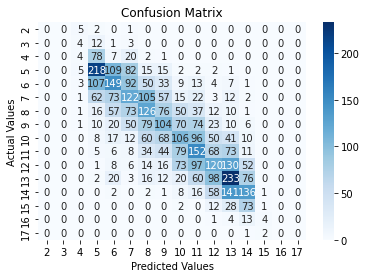

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, clf.predict(X_test), labels=None, sample_weight=None)

cm_df =  pd.DataFrame(cm, index= [i for i in np.sort(y_test.unique())],
                     columns= [i for i in np.sort(y_test.unique())])
sns.heatmap(cm_df, annot=True,cmap='Blues',fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

The accuracy of the model is not very high. With more time, we would have try to improve it and test other type of models. 
Nonetheless, it seems that the inaccuracy is +1 or -1 class around each class. Using 20 class is quite high for a sentiment classification model. Many model would only try to classify in 4 classes for instance (very good, good, bad, very bad).
The less class we are using and the higher the accuracy will be of course but as we want to improve the simple star rating, we belive that for this project, this is already an improvement. With more time, this can defintely be improved as well as trying other way of makeing a sentiment score. 

## **3) Model prediction on the yelp dataset**

The dataset is being stored in our database and will be updated once a week with new reviews. 

The model will be run once a week after the update and then the sentiment predicted. This simple batch processing allows us to save GPU and make the app faster.

In [ ]:
# Load the sentiment analysis model
sentiment_model = pickle.load(open('../input/sentimentmodelyelp/sentiment_model_20Classes.sav', 'rb'))

sentiment = []
def analyse_sentiment(text):
    token_text = text_data_cleaning(text)
    token_text2 = [' '.join(token_text)]
    sent = sentiment_model.predict(token_text2)
    return sent

sentiment = reviews['text'].apply(analyse_sentiment)
sentiment_cl = [i[0] for i in sentiment]
reviews['sentiment'] = sentiment_cl

We are now adding these different parameters to the files buisness and reviews

In [ ]:
# calculating the average star rating, sentiment, useful, funny and cool parameters
avgRest = reviews_NW.groupby(['business_id']).mean()

# adding the averages parameters to the reviews file
reviews_NW = reviews_NW.set_index('business_id')
reviews_final = reviews_NW.join(avgRest,rsuffix='_avg')

# adding the averages parameters to the buisness file
business_NW = business_NW.set_index('business_id')
business_final = business_NW.join(avgRest,rsuffix='_avg')

In [ ]:
reviews_final.head()

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,sentiment,stars_avg,useful_avg,funny_avg,cool_avg,sentiment_avg
0,--0iUa4sNDFiZFrAdIWhZQ,o2QietGCr_V8HyrCkZB1uA,rspP9vDPeXMAfzC6Jj2vaw,4,4,0,0,Very good San Salvadorian place ! Authentic an...,2012-07-19 05:52:27,12,3.214286,1.785714,0.214286,0.285714,9.785714
1,--0iUa4sNDFiZFrAdIWhZQ,3BIp3g268nZ0HFhjHDr0Lw,Dr-atSrDQURhT9GiHn8D4Q,1,2,0,0,Didn't even get to try the papusas. Went in an...,2017-02-12 18:34:45,5,3.214286,1.785714,0.214286,0.285714,9.785714
2,--0iUa4sNDFiZFrAdIWhZQ,vmhIoWdIE8TCEewyJqOVeA,ojO2tgUhpJGUsU2mMBL24A,1,0,0,0,"If I could give 0 stars, I would. Ordered some...",2016-09-21 18:37:44,5,3.214286,1.785714,0.214286,0.285714,9.785714
3,--0iUa4sNDFiZFrAdIWhZQ,xlFTwZzBU1MttIiWZkL2eQ,6AjDticsrHFZoYoHEfDVWg,3,1,1,0,Dont be fooled by the 3 star rating. This pla...,2013-06-29 03:23:15,12,3.214286,1.785714,0.214286,0.285714,9.785714
4,--0iUa4sNDFiZFrAdIWhZQ,KBrJv6UNBRdBYHDqk5cU_w,tcTWVqBY2ayhj0EAJKM57w,3,0,0,0,"Building very clean, service slow but that's c...",2015-09-06 19:20:31,11,3.214286,1.785714,0.214286,0.285714,9.785714


In [ ]:
business_final.head()

,business_id,Unnamed: 0,name,address,city,state,postal_code,latitude,longitude,stars,...,attributes,categories,hours,restaurant,categories_mod,stars_avg,useful,funny,cool,sentiment
0,MTSW4McQd7CbVtyjqoe9mw,3,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,...,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True,"['restaurants', 'food', 'bubble', 'tea', 'coff...",4.057471,1.505747,0.540230,1.091954,11.022989
1,mWMc6_wTdE0EUBKIGXDVfA,4,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,...,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",True,"['brewpubs', 'breweries', 'food']",4.692308,0.153846,0.000000,0.000000,12.076923
2,MUTTqe8uqyMdBl186RmNeA,15,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,...,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",True,"['sushi', 'bars', 'restaurants', 'japanese']",4.200000,1.304000,0.252000,0.656000,11.504000
3,ROeacJQwBeh05Rqg7F6TCg,19,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,...,"{'NoiseLevel': ""u'quiet'"", 'GoodForMeal': ""{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",True,"['korean', 'restaurant']",4.317308,0.798077,0.235577,0.423077,11.663462
4,kV_Q1oqis8Qli8dUoGpTyQ,33,Ardmore Pizza,10 Rittenhouse Pl,Ardmore,PA,19003,40.006707,-75.289671,3.5,...,"{'RestaurantsGoodForGroups': 'True', 'WiFi': ""...","Pizza, Restaurants","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",True,"['pizza', 'restaurants']",3.482456,0.605263,0.298246,0.333333,10.157895


In [ ]:
# Save the files to be used in the app. These are the files that are updated each week
reviews_final.to_csv('reviews_NW_all_Scores_final.csv')
business_final.to_csv('business_NW_Scores_final.csv')

The output of this last cells is saved to the database and is queried everytime a user input is processed. When new reviews added the model is re-run and new sentiment score are calculated and stored. This process is repeated at pre=set intervals e.g weekly.

# Conclusion and Lesson's Learned
 > Natural language processing techniques can be used to make apps 'smarter'

 > Because computers do not process language like humans, it's difficult to train models to fully comprehend text input as you can see from our models.
 
 > Machine learning models can be used for NLP tasks with the addition of pre-processing. However, the choice of model used and type of data affects performance. Sklearn logistic regression models are basic and perfomed fairly well on simple classification but had more difficulties with sentiment analysis.
